# Chapter 15: Deep Q-Learning

In Chapters 13 and 14, you used tabular Q-learning to train a Q table. You then use the trained Q-table to successfully play the OpenAI Gym Frozen Lake game and the Mountain Car game. 

In many situations, the number of possible scenarios is too large. Examples include Chess or the Go game: the number of possible board positions is astronomical. It’s impractical to create a Q table for these types of games for two reasons: First, the computer will not have enough memory to save and update a Q table with so many different rows (each row represents a different scenario); Second, it's impossible to calculate and update the correct Q values because the size of the Q-table is too large. 

That's when deep neural networks can help. Neural networks are function approximators and we’ll use a deep neural network to approximate the Q values. That’s the idea behind deep Q learning. 

This chapter will apply deep Q learning to a game that you have played before in Chapter 9: the Cart Pole game. You’ll learn how to calculate the Q tables by using deep Q networks, so that you can tackle much more complicated games later in this book (such as Breakout, Space Invaders and other Atari games).

At the end of this chapter, you'll create an animation to illustrate how deep Q learning works. Specifically, at each time step, you'll put the graph of the cart pole on the left. You'll draw on the right the current state of the game: cart position, cart velocity, pole angle, and pole velocity. You'll feed the information to the trained deep Q network to get the Q-values of moving the cart left and moving the cart right, respectively. The move with higher Q-value is then highlighted in red on the graph, and that's the action taken by the agent. You'll repeat this in each of the 200 time steps, like so:  
<img src="https://gattonweb.uky.edu/faculty/lium/ml/cartpole_DeepQs.gif" />

***
$\mathbf{\text{Create a subfolder for files in Chapter 15}}$<br>
***
We'll put all files in Chapter 15 in a subfolder /files/ch15. The code in the cell below will create the subfolder.

***

In [1]:
import os

os.makedirs("files/ch15", exist_ok=True)

## 1. Deep Q-Learning: Train the Model for the Cart Pole Game

The input of the deep Q-learning model is the state of the game, just as in deep learning models. However, the output layers are different. In deep learning models in Chapter 9, the output is the probability of winning. There is only one neuron in the output layer. 

In contrast, in deep Q-learning, the number of neurons in the output layer is the same as the number of actions. The output are the Q values of the state-action pair. More on this later.

### 1.1. Create the Deep Q Network

If you recall, in Chapter 9, the deep neural network that we created for traing the deep learning game strategies is as follows:

```python
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(5,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
```
The input dimension is five because the dimension of the state is 4, and the dimension of the action is 1. So we feed the model a state-action pair, which has a dimension of 5. 

In deep Q networks, we feed the model the current state of the game. So the input shape is 4 in the Cart Pole game. We'll change the number of neurons to 2 in the output layer because there are two possible actions in the Cart Pole game: moving left and moving right. 

Therefore, the model we'll use is as follows:

```python
model = Sequential()
model.add(Dense(32, activation='elu', input_shape=(4,)))
model.add(Dense(32, activation='elu'))
model.add(Dense(2))
```
Note that we don't use any activation function in the output layer in deep Q newtworks since the Q-values can potentially go from $-\infty$ to $\infty$.

### 1.2. Train the Deep Q Network
The following script trains the deep Q network for the Cart Pole game. It stops until the average score is at least 195 in the past 100 games. That is, the cart pole needs to stay upright for at leat 195 consecutive time steps on average in each of the last 100 games.

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Discount factor for past rewards
gamma = 0.95  
# Size of batch taken from replay buffer
batch_size = 32  
max_steps_per_episode = 200

env = gym.make("CartPole-v0")

input_shape = [4] 
n_outputs = 


num_actions = 2


def create_q_model():
    model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

    return model



model = create_q_model()


optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 1000


max_memory_length = 2000

# Run until solved
while True:  
    state = np.array(env.reset())
    episode_reward = 0
    epsilon = max(1 - episode_count / 500, 0.01)
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # once batch size is over 32
        if len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_fn(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))


        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1



    template = "running reward: {:.2f} at episode {}, "
    print(template.format(running_reward, episode_count))


    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break


model.save("files/ch15/cartpole_deepQ.h5")


The model is considered trained if the averge score in the past 100 games is 195 or above, as stated by the OpenAI Gym rules. That's the criteria used in the training process. Once the goal is achieved, the training stops. 

The above program takes about an hour to run, depending on the speed of your computer. Here is the output from my computer

```python
...
...
running reward: 193.93 at episode 859, 
running reward: 194.24 at episode 860, 
running reward: 194.24 at episode 861, 
running reward: 194.37 at episode 862, 
running reward: 194.67 at episode 863, 
running reward: 194.75 at episode 864, 
running reward: 194.89 at episode 865, 
running reward: 195.20 at episode 866, 
Solved at episode 866!
```

## 2. Test the Deep Q Network

Now that the model is trained, we can use it to play the OpenAI Gym Cart Pole game and see if it works. 

### 2.1. Test One Game
Next, we'll test one game, with the graphical rendering turned on.

In [3]:
# Load the trained Deep Q Network
reload = tf.keras.models.load_model("files/ch15/cartpole_deepQ.h5")
env = gym.make('CartPole-v0')
state = env.reset()

# We'll also save the game history for animation later
history = []
score = 0
for i in range(1,201):
    # Save the screen for later use
    frame=env.render(mode='rgb_array')
    # Use the trained model to predict the prob of winning 
    X_state = np.array(state).reshape(-1,4)
    prediction = reload.predict(X_state)
    # pick the action with higher probability of winning
    action = np.argmax(prediction)
    new_state, reward, done, info = env.step(action)
    history.append([frame, state, action, prediction])
    state = new_state
    score += 1
    if done == True:
        print(f"score is {score}")
        break
env.close()

score is 200


The score is 200. So the cart pole stayed upright for all 200 time steps. The deep Q network really works!!!

Note that we recorded the game history in every step, including the frame, the state, the predictions, and the action taken by the agent. We'll need all those pieces of information later when we create an animation of the deep Q-learning process. Therefore, we save the data on the computer now. 

In [ ]:
import pickle
# save the simulation data on your computer
with open('files/ch15/CartPole_game_history.p', 'wb') as fp:
    pickle.dump(history, fp)

### 2.2. Test the Efficacy of the Deep Q Network
Next, we play the game 100 times using the trained deep Q network and see how effective the trained deep Q network is on average. 

In [ ]:
reload = tf.keras.models.load_model("files/ch15/cartpole_deepQ.h5")
env = gym.make('CartPole-v0')

def test_cartpole():
    state = env.reset()
    score = 0
    for i in range(1,201):
        # Use the trained model to predict the prob of winning 
        X_state = np.array(state).reshape(-1,4)
        prediction = reload.predict(X_state)
        # pick the action with higher probability of winning
        action = np.argmax(prediction)
        new_state, reward, done, info = env.step(action)
        state = new_state
        score += 1
        if done == True:
            break

    return score

#repeat the game 100 times and record all game outcomes
results=[]        
for x in range(100):
    result=test_cartpole()
    results.append(result)    

#print out the average score
average_score = np.array(results).mean()
print("the average score is", average_score)

env.close()

the average score is 200.0

So the trained deep Q network managed to make the cart pole stay upright for 200 consecutive time steps in every sigle game. 

## 3. Animate the Deep Q Learning Game Strategies
Next, we'll animate how the agent uses the trained deep Q network to design game strategies. 

Specifically, in each time step, the agent looks at the current state, which is an array with four values:
* The position of the cart, with values between -4.8 and 4.8; 
* The velocity of the cart, with values between -4 and 4; 
* The angle of the pole, with values between -0.42 and 0.42;
* The angular velocity of the pole, with values between -4 and 4; 

The agent feeds the array into the trained deep Q network and gets two Q values: the first is the Q value for taking action 0 (i.e., moving left); the second is the Q value for taking action 1 (i.e., moving right). The agent compares the two values and takes the action with the higher Q value.  

The agent repeats the process until the game ends.

In each time step, you'll put the graph of the cart pole on the left. You'll draw on the right the current state of the game: cart position, cart velocity, pole angle, and pole velocity. You'll also draw the Q-values of moving the cart left and moving the cart right, respectively. The move with higher Q-value is then highlighted in red, and that's the action taken by the agent. 

Once you have a graph for each time step, you'll combine them into an animation.

### 3.1. Create A Graph of the Current State and Q-Values
Each Cart Pole game has a maximum of 200 time steps. In each time step, you'll put the cart pole on the left, and the current state and the Q-values on the right.

The script below accomplishes that.

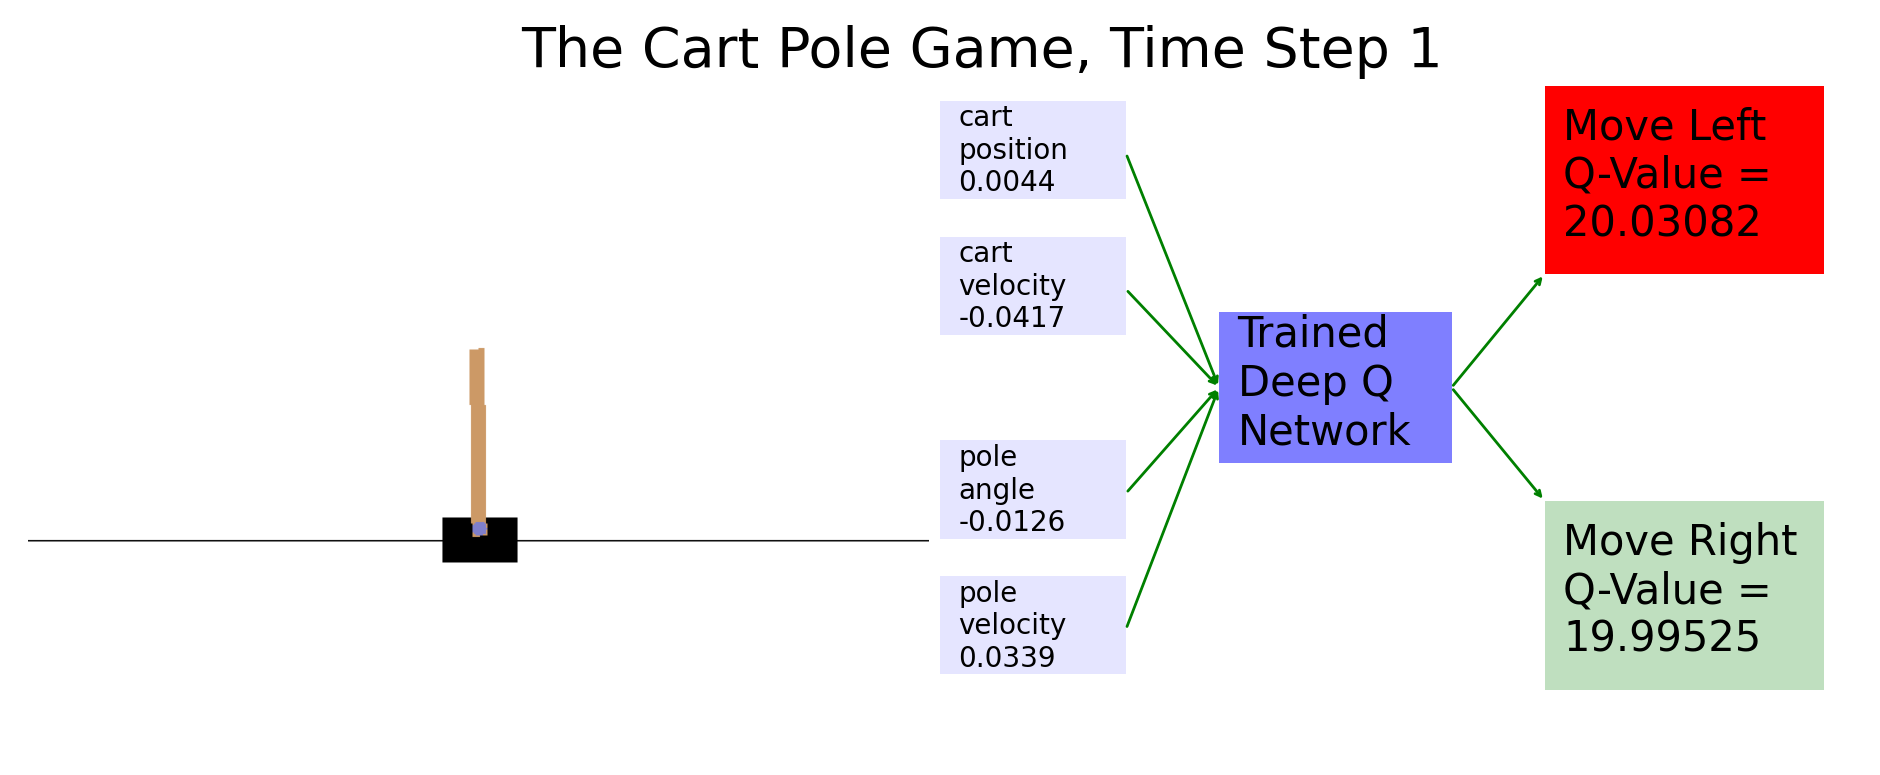

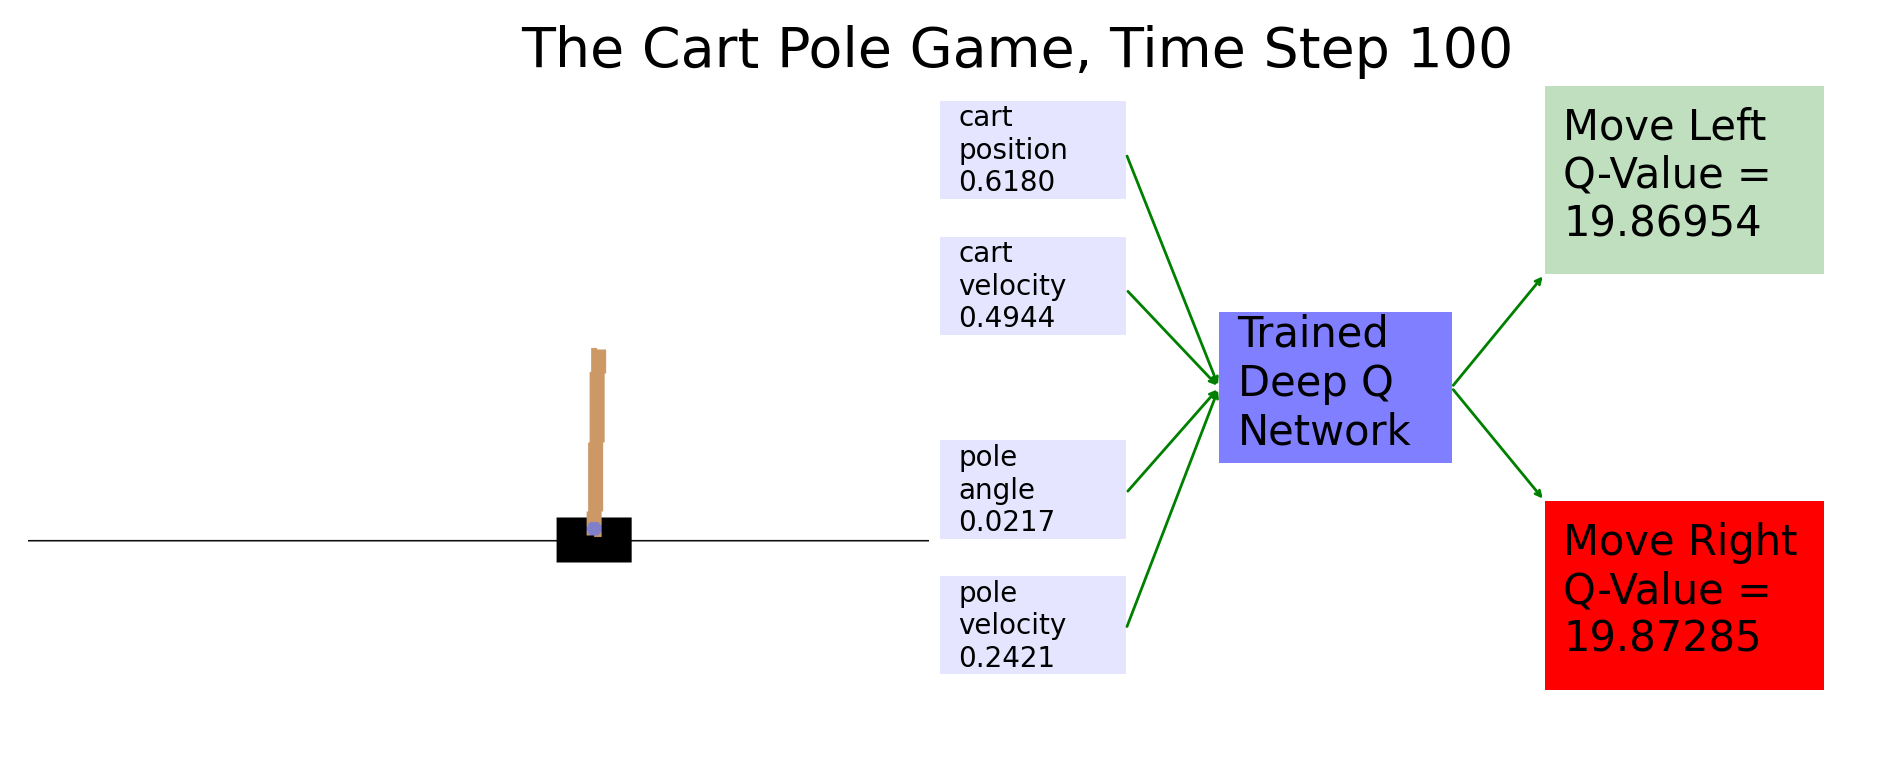

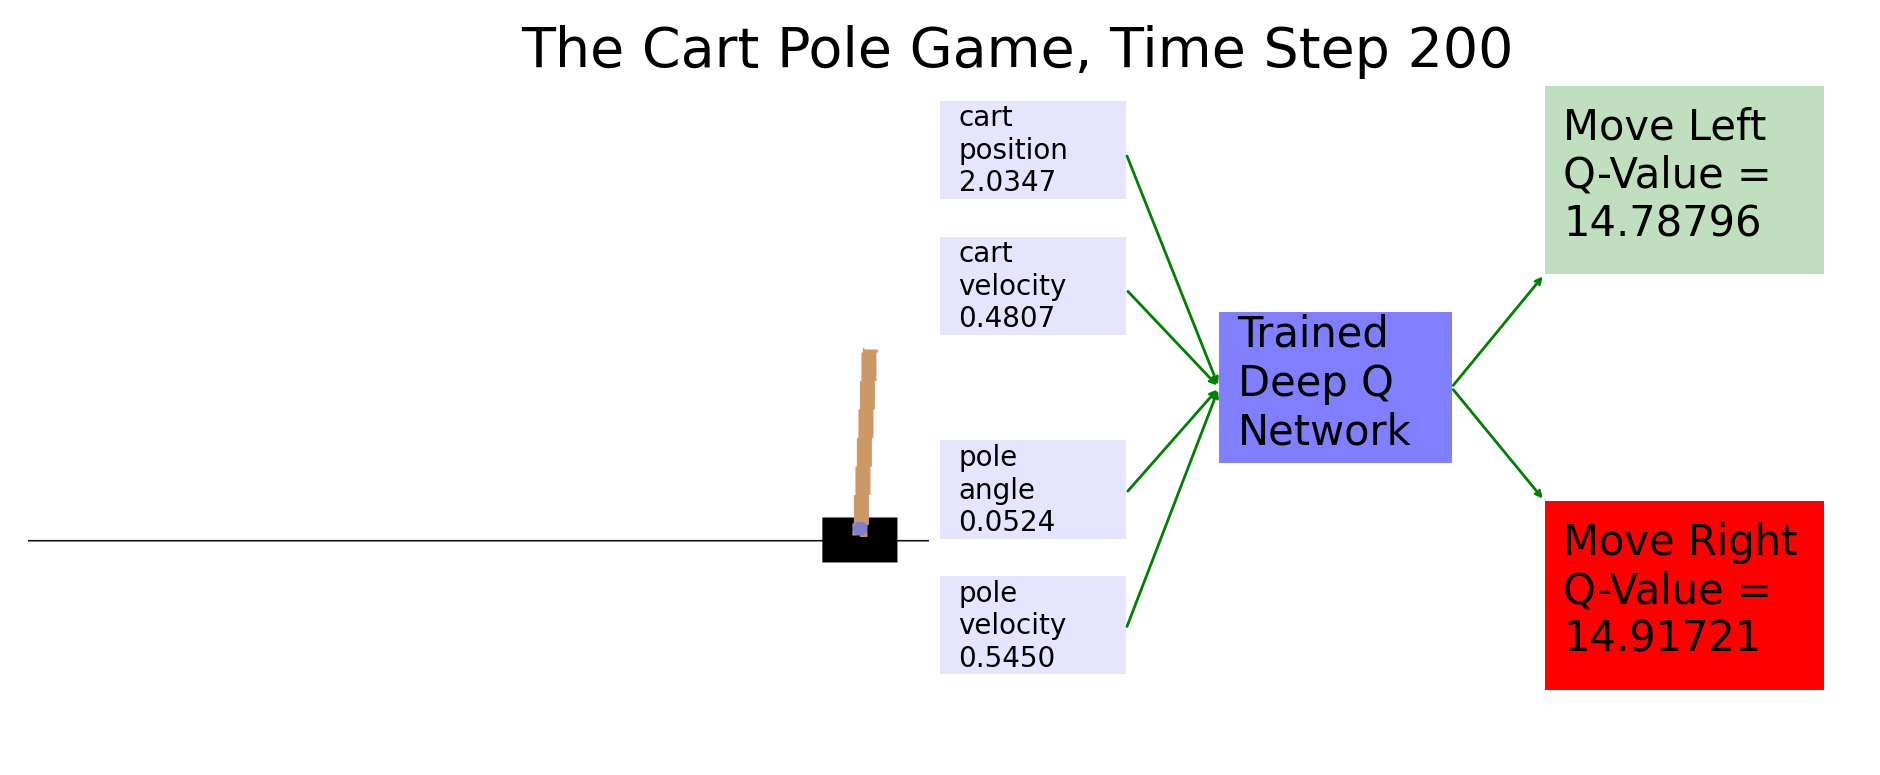

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import os

import numpy as np

# Load up date during the training process

# save the simulation data on your computer
inputs = ["cart\nposition","cart\nvelocity","pole\nangle","pole\nvelocity"]
hs = [3.1,1.3,-1.4,-3.2]

history=pickle.load(open('files/ch15/CartPole_game_history.p', 'rb'))
frames = []
states = []
actions = []
predictions = []

for item in history:
    frame, state, action, prediction = item
    frames.append(frame)
    states.append(state)
    actions.append(action)
    predictions.append(prediction[0])

for step in [0, 99, 199]:
      
    fig = plt.figure(figsize=(24,10), dpi=100)
    ax = fig.add_subplot(111) 
    ax.set_xlim(-10, 10)
    ax.set_ylim(-5,5)
    #plt.grid()
    plt.axis("off")
    ax.text(-4.5,4.25,f"The Cart Pole Game, Time Step {step+1}",fontsize=40)

    # Add deep Q network
    ax.add_patch(Rectangle((3, -1), 2.5, 2,
                 facecolor = 'b',alpha=0.5)) 
    ax.text(3.2,-0.75,"Trained \nDeep Q\nNetwork",fontsize=30)

    # Add output boxes
    ax.add_patch(Rectangle((6.5, 1.5), 3,2.5,
                 facecolor = 'g',alpha=0.25))
    ax.add_patch(Rectangle((6.5, -4), 3,2.5,
                 facecolor = 'g',alpha=0.25)) 
    ax.text(6.7,2,f"Move Left \nQ-Value =\n{predictions[step][0]:.5f}",fontsize=30)
    ax.text(6.7,-3.5,f"Move Right \nQ-Value =\n{predictions[step][1]:.5f}",fontsize=30)
    ax.annotate("",xy=(6.5,1.5),xytext=(5.5,0),
        arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 2))
    ax.annotate("",xy=(6.5,-1.5),xytext=(5.5,0),
        arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 2))

    # highlight the best action
    ax.add_patch(Rectangle((6.5, 1.5-5.5*actions[step]), 3,2.5,facecolor='r'))   

    # add rectangle to plot
    for i in range(4):
        ax.add_patch(Rectangle((0,-0.6+hs[i]), 2, 1.3,
                     facecolor = 'b',alpha=0.1)) 
        plt.text(0.2,hs[i]-0.5,f"{inputs[i]}\n{states[step][i]:.4f}",fontsize=20)   
        ax.annotate("",xy=(3,0),xytext=(2,hs[i]),
        arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 2))   

    # Add new picture
    newax = fig.add_axes([0.02, 0.2, 0.6, 0.6])
    newax.imshow(frames[step])
    newax.axis('off') 
    plt.savefig(f"files/ch15/cartpole_DeepQ{step+1}.png")


The script generates three graphs: one in step 1, one in step 100, and one in step 200. 

If you open the cartpole_DeepQ1.png in your local folder, you'll see a picture as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/cartpole_DeepQ1.png"/>
The cartpole position is on the left. The current state, [0.0044, -0.0417, -0.0126, 0.0339], is also showing on the graph. The two Q-values are 20.03082 and 19.99525. Since the first Q-value is greater, it's highlighted in red. The agent therefore takes action 0 in the first step. 

The pictures cartpole_DeepQ100.png and cartpole_DeepQ200.png are similar but with different cartpole positions, state values, and Q-values.  

### 3.2. Create A Graph for Each Time Step
Next, we'll create a graph for each of the 200 steps. To save space on the computer, we'll not save all the pictures. Instead, we'll put them in a list temporarily.

In [2]:
graphs = []
for step in range(0,200):
    fig = plt.figure(figsize=(24,10), dpi=100)
    ax = fig.add_subplot(111) 
    ax.set_xlim(-10, 10)
    ax.set_ylim(-5,5)
    #plt.grid()
    plt.axis("off")
    ax.text(-4.5,4.25,f"The Cart Pole Game, Time Step {step+1}",fontsize=40)

    # Add deep Q network
    ax.add_patch(Rectangle((3, -1), 2.5, 2,
                 facecolor = 'b',alpha=0.5)) 
    ax.text(3.2,-0.75,"Trained \nDeep Q\nNetwork",fontsize=30)

    # Add output boxes
    ax.add_patch(Rectangle((6.5, 1.5), 3,2.5,
                 facecolor = 'g',alpha=0.25))
    ax.add_patch(Rectangle((6.5, -4), 3,2.5,
                 facecolor = 'g',alpha=0.25)) 
    ax.text(6.7,2,f"Move Left \nQ-Value =\n{predictions[step][0]:.5f}",fontsize=30)
    ax.text(6.7,-3.5,f"Move Right \nQ-Value =\n{predictions[step][1]:.5f}",fontsize=30)
    ax.annotate("",xy=(6.5,1.5),xytext=(5.5,0),
        arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 2))
    ax.annotate("",xy=(6.5,-1.5),xytext=(5.5,0),
        arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 2))

    # highlight the best action
    ax.add_patch(Rectangle((6.5, 1.5-5.5*actions[step]), 3,2.5,facecolor='r'))   

    # add rectangle to plot
    for i in range(4):
        ax.add_patch(Rectangle((0,-0.6+hs[i]), 2, 1.3,
                     facecolor = 'b',alpha=0.1)) 
        plt.text(0.2,hs[i]-0.5,f"{inputs[i]}\n{states[step][i]:.4f}",fontsize=20)   
        ax.annotate("",xy=(3,0),xytext=(2,hs[i]),
        arrowprops=dict(arrowstyle = '->', color = 'g', linewidth = 2))   

    # Add new picture
    newax = fig.add_axes([0.02, 0.2, 0.6, 0.6])
    newax.imshow(frames[step])
    newax.axis('off') 

    fig.canvas.draw()
    # Now we can save it to a numpy array.
    graph = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    graph = graph.reshape(fig.canvas.get_width_height()[::-1]+ (3,))
    graphs.append(graph)
    plt.close(fig)

The list *graphs* contains 200 numpy arrays. Each array is a picture in each of the 200 time steps. 

### 5.3. Create An Animation
We'll use the ***imageio*** library to convert the 200 graphs into an animation.

In [3]:
import imageio
imageio.mimsave('files/ch15/cartpole_DeepQ.gif', graphs, fps=12)  

The animation looks as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/cartpole_DeepQs.gif" />